In [1]:
import torch
import os
import random
import datetime
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix

In [2]:
import tqdm

Image 1: US07314871-20080101-C00205.png - Image 2: US07314871-20080101-C00205.png
Image 1: US07314887-20080101-C00073.png - Image 2: US07314887-20080101-C00073.png
Image 1: US07323608-20080129-C00064.png - Image 2: US07323608-20080129-C00064.png
Image 1: US07314883-20080101-C00258.png - Image 2: US07314883-20080101-C00258.png
Image 1: US07323447-20080129-C00278.png - Image 2: US07323447-20080129-C00278.png
Image 1: US07314937-20080101-C00226.png - Image 2: US07314937-20080101-C00226.png
Image 1: US07314934-20080101-C00119.png - Image 2: US07314934-20080101-C00119.png
Image 1: US07314938-20080101-C00208.png - Image 2: US07314938-20080101-C00208.png
Image 1: US07317125-20080108-C00050.png - Image 2: US07317125-20080108-C00050.png
Image 1: US07314937-20080101-C00196.png - Image 2: US07314937-20080101-C00196.png


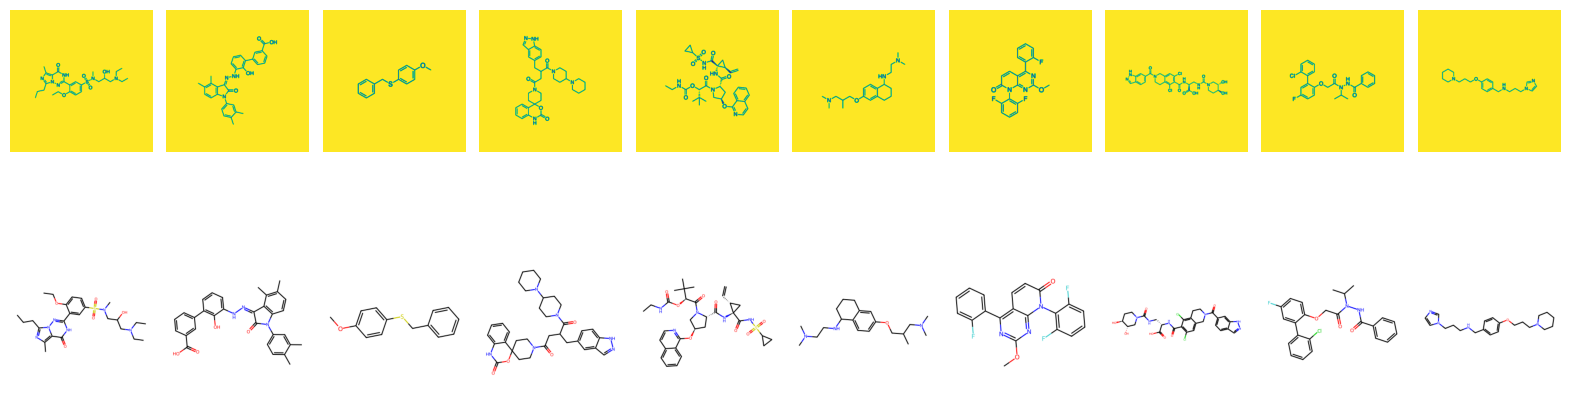

In [3]:
def check_matching_image_counts(root_dir1, root_dir2):
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    return num_images_dir1 == num_images_dir2

def get_matching_indices(root_dir1, root_dir2):
    indices = []
    
    num_images_dir1 = len(os.listdir(root_dir1))
    num_images_dir2 = len(os.listdir(root_dir2))
    
    min_num_images = min(num_images_dir1, num_images_dir2)
    
    for i in range(min_num_images):
        indices.append(i)
        
    return indices

def plot_random_images(root_dir1, root_dir2, num_images=10):
    fig, axes = plt.subplots(2, num_images, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    
    # Check if the number of images in each directory matches
    matching_counts = check_matching_image_counts(root_dir1, root_dir2)
    if not matching_counts:
        print("Error: Number of images in each directory does not match.")
        return
    
    # Get matching indices for images from each directory
    indices = get_matching_indices(root_dir1, root_dir2)
    
    # Get random subset of indices
    selected_indices = random.sample(indices, min(num_images, len(indices)))
    
    # Lists to store image names
    img_names1 = []
    img_names2 = []
    
    # Plot images from both directories with the same indices
    for i, idx in enumerate(selected_indices):
        img_name = os.listdir(root_dir1)[idx]
        img_names1.append(img_name)
        img_names2.append(img_name)
        
        img_path_dir1 = os.path.join(root_dir1, img_name)
        img_path_dir2 = os.path.join(root_dir2, img_name)
        
        img_dir1 = Image.open(img_path_dir1)
        img_dir2 = Image.open(img_path_dir2)
        
        axes[0, i].imshow(img_dir1)
        axes[0, i].axis('off')
        
        axes[1, i].imshow(img_dir2)
        axes[1, i].axis('off')
    
    # Print paired image names
    for name1, name2 in zip(img_names1, img_names2):
        print(f"Image 1: {name1} - Image 2: {name2}")
    
    plt.show()

# 경로 설정
root_dir1 = 'data/train/chemdraw_train'
root_dir2 = 'data/train/chemdraw_train_smlies'

# 이미지 플로팅
plot_random_images(root_dir1, root_dir2)

In [4]:
class ImagePairDataset(Dataset):
    def __init__(self, root_dir1, root_dir2, label, transform=None):
        self.root_dir1 = root_dir1
        self.root_dir2 = root_dir2
        self.label = label
        self.transform = transform
        self.samples = []
        
        # 두 디렉토리 안의 이미지 파일을 쌍으로 찾기
        for filename in os.listdir(root_dir1):
            img1_path = os.path.join(root_dir1, filename)
            img2_path = os.path.join(root_dir2, filename)
            if os.path.isfile(img1_path) and os.path.isfile(img2_path):
                # 올바른 쌍인 경우 레이블을 설정
                img1 = self.read_image(img1_path)
                img2 = self.read_image(img2_path)
                self.samples.append((img1, img2, self.label))


    def __len__(self):
        return len(self.samples)

    
    def __getitem__(self, idx):
        return self.samples[idx]

    
    def read_image(self, filepath):
        img = Image.open(filepath).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [5]:
class CombinedImagePairDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.total_length = len(dataset1) + len(dataset2)

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        if idx < len(self.dataset1):
            img1, img2, label = self.dataset1[idx]
            return img1, img2, label
        else:
            # Adjust the index to fit within the second dataset
            adjusted_idx = idx - len(self.dataset1)
            img1, img2, label = self.dataset2[adjusted_idx]
            return img1, img2, label

In [6]:
class ImageComparisonModel(nn.Module):
    def __init__(self):
        super(ImageComparisonModel, self).__init__()
        
        # Stream 1 for the first image modality
        self.stream1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Stream 2 for the second image modality
        self.stream2 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fusion and decision mechanism
        self.comparison = nn.Sequential(
            nn.Linear(16*16*256*2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1),  # Binary classification
        )
        
    def forward(self, x1, x2):
        x1 = self.stream1(x1)
        x2 = self.stream2(x2)
        
        # Flatten the features from both streams
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
        
        # Concatenate the features
        x = torch.cat((x1, x2), dim=1)
        
        # Pass through the comparison mechanism
        x = self.comparison(x)
        # Apply softmax to get probabilities
        # x = F.softmax(x, dim=1)
        return x

In [7]:
# # 모델 초기화
combined_model = ImageComparisonModel()

print(combined_model)

ImageComparisonModel(
  (stream1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stream2): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNo

In [8]:
# 이미지 전처리 설정
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 이미지 크기를 64x64로 조정
    transforms.ToTensor(),         # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

In [9]:
batch_size = 8

In [10]:
# 경로 설정

chemdraw_train = "data/train/chemdraw_train"
chemdraw_test = "data/test/chemdraw_test"
chemdraw_valid = "data/valid/chemdraw_val"

chemdraw_train_smlies = "data/train/chemdraw_train_smlies"
chemdraw_test_smlies = "data/test/chemdraw_test_smlies"
chemdraw_valid_smlies = "data/valid/chemdraw_val_smlies"

chemdraw_train_smlies_wrong = "data/train/chemdraw_train_smlies_wrong"
chemdraw_test_smlies_wrong = "data/test/chemdraw_test_smlies_wrong"
chemdraw_valid_smlies_wrong = "data/valid/chemdraw_val_smlies_wrong"

In [11]:
# 학습 데이터셋 생성
combine_train_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_train, chemdraw_train_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_train, chemdraw_train_smlies_wrong, 0, transform=transform))
combine_test_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_test, chemdraw_test_smlies, 1, transform=transform),
                                                ImagePairDataset(chemdraw_test, chemdraw_test_smlies_wrong, 0, transform=transform))
combine_valid_dataset = CombinedImagePairDataset(ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies, 1, transform=transform),
                                                 ImagePairDataset(chemdraw_valid, chemdraw_valid_smlies_wrong, 0, transform=transform))

# 데이터로더 생성
train_loader = DataLoader(combine_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(combine_test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(combine_valid_dataset, batch_size=batch_size, shuffle=False)

In [12]:
print(combine_train_dataset.dataset1.root_dir1)
print(combine_train_dataset.dataset1.root_dir2)

print(combine_test_dataset.dataset1.root_dir1)
print(combine_test_dataset.dataset1.root_dir2)

print(combine_valid_dataset.dataset1.root_dir1)
print(combine_valid_dataset.dataset1.root_dir2)

data/train/chemdraw_train
data/train/chemdraw_train_smlies
data/test/chemdraw_test
data/test/chemdraw_test_smlies
data/valid/chemdraw_val
data/valid/chemdraw_val_smlies


In [13]:
# GPU를 사용할 수 있는지 확인합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = combined_model.to(device)

print(device)

cuda


In [14]:
# 학습을 위한 하이퍼파라미터 설정
learning_rate = 1e-5
num_epochs = 200

# 손실 함수 정의
criterion = nn.BCEWithLogitsLoss()

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(criterion)

BCEWithLogitsLoss()


In [15]:
save_model_path = "Check_Model"

def save_model(model, save_path, acc):
    # 새로운 폴더 생성 (없으면)
    os.makedirs(save_path, exist_ok=True)
    # 현재 시간 가져오기
    now = datetime.datetime.now()
    # 모델 저장
    torch.save(model.state_dict(), os.path.join(save_path, f"model_{now.strftime('%Y%m%d_%H%M%S')}_{acc}.pth"))


def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    valid_losses = []
    best_valid_loss = float('inf')
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        
        # 훈련 데이터로 모델 학습
        for inputs1, inputs2, labels in tqdm.tqdm(train_loader, total=len(train_loader)):
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)
            outputs = outputs.squeeze()
            # 모델 출력의 크기와 레이블의 크기를 맞추기 위해 labels을 [batch_size, 2]로 변경
            #labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            #print(f'[DEBUG] Train Loss: {loss.item():.8f}')
        
        # 평균 훈련 손실 계산
        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0
        
        # 검증 데이터로 모델 평가
        with torch.no_grad():
            for inputs1, inputs2, labels in tqdm.tqdm(valid_loader, total=len(valid_loader)):
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)
                outputs = outputs.squeeze()
                # 모델 출력의 크기와 레이블의 크기를 맞추기 위해 labels을 [batch_size, 2]로 변경
                #labels = torch.nn.functional.one_hot(labels, num_classes=2).float()
                loss = criterion(outputs, labels.float())
                running_valid_loss += loss.item()
                
                # 정확도 계산
                #_, predicted = torch.max(outputs, 1)
                #predicted = predicted.unsqueeze(1)  # predicted를 [batch_size, 1]로 변경
                predicted = (outputs > 0).long()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        # 평균 검증 손실 계산
        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        # 정확도 계산
        accuracy = correct / total
        
        # 에포크마다 학습 결과 출력
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.8f}, Valid Loss: {epoch_valid_loss:.8f}, Accuracy: {accuracy:.8f}')
        
        # 20번의 에폭이 끝날 때마다 최고 정확도를 확인하고 모델 저장
        if (epoch + 1) % 20 == 0:
            if save_path:
                save_model(model, save_path, best_accuracy)
                print("모델이 저장되었습니다.")
                
        # 모델의 손실이 더 낮아졌을 때 저장
        #if epoch_valid_loss < best_valid_loss:
        #    best_valid_loss = epoch_valid_loss
        #    if save_path:
        #        save_model(model, save_path)

        #print("모델이 저장되었습니다.")
    return train_losses, valid_losses, best_accuracy

In [16]:
# 모델 학습
# num_epochs = 3
train_losses, valid_losses, best_accuracy = train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, save_model_path)

100%|██████████| 130/130 [00:01<00:00, 93.33it/s]


Epoch 1/200, Train Loss: 0.66042115, Valid Loss: 0.58942096, Accuracy: 0.71346154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.71it/s]


Epoch 2/200, Train Loss: 0.60337506, Valid Loss: 0.55578318, Accuracy: 0.75384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.99it/s]


Epoch 3/200, Train Loss: 0.55911110, Valid Loss: 0.51677989, Accuracy: 0.78269231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.99it/s]


Epoch 4/200, Train Loss: 0.52025951, Valid Loss: 0.46901387, Accuracy: 0.81730769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.80it/s]


Epoch 5/200, Train Loss: 0.47810803, Valid Loss: 0.43896070, Accuracy: 0.84423077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.40it/s]


Epoch 6/200, Train Loss: 0.43868570, Valid Loss: 0.42885598, Accuracy: 0.83653846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.05it/s]


Epoch 7/200, Train Loss: 0.40232376, Valid Loss: 0.41271022, Accuracy: 0.84038462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.35it/s]


Epoch 8/200, Train Loss: 0.36800276, Valid Loss: 0.37620273, Accuracy: 0.86538462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.13it/s]


Epoch 9/200, Train Loss: 0.33659681, Valid Loss: 0.37259730, Accuracy: 0.85288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.45it/s]


Epoch 10/200, Train Loss: 0.31194358, Valid Loss: 0.35168087, Accuracy: 0.86826923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 11/200, Train Loss: 0.28786060, Valid Loss: 0.34149847, Accuracy: 0.85961538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.30it/s]


Epoch 12/200, Train Loss: 0.26703194, Valid Loss: 0.32142299, Accuracy: 0.87692308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.99it/s]


Epoch 13/200, Train Loss: 0.25246909, Valid Loss: 0.34282542, Accuracy: 0.86442308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.26it/s]


Epoch 14/200, Train Loss: 0.23561846, Valid Loss: 0.32583256, Accuracy: 0.86250000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.15it/s]


Epoch 15/200, Train Loss: 0.21635364, Valid Loss: 0.36093976, Accuracy: 0.84134615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.16it/s]


Epoch 16/200, Train Loss: 0.20626432, Valid Loss: 0.33424643, Accuracy: 0.85384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.13it/s]


Epoch 17/200, Train Loss: 0.19827734, Valid Loss: 0.30056445, Accuracy: 0.87019231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.87it/s]


Epoch 18/200, Train Loss: 0.19124837, Valid Loss: 0.34877731, Accuracy: 0.85576923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.18it/s]


Epoch 19/200, Train Loss: 0.17811821, Valid Loss: 0.32384476, Accuracy: 0.86250000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.09it/s]


Epoch 20/200, Train Loss: 0.16785582, Valid Loss: 0.33382185, Accuracy: 0.85769231
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.29it/s]


Epoch 21/200, Train Loss: 0.16668078, Valid Loss: 0.26890677, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.07it/s]


Epoch 22/200, Train Loss: 0.14952118, Valid Loss: 0.29059450, Accuracy: 0.88557692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.89it/s]


Epoch 23/200, Train Loss: 0.14555050, Valid Loss: 0.30699927, Accuracy: 0.87211538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.41it/s]


Epoch 24/200, Train Loss: 0.14560952, Valid Loss: 0.28112709, Accuracy: 0.89519231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.10it/s]


Epoch 25/200, Train Loss: 0.14184841, Valid Loss: 0.28445831, Accuracy: 0.88653846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.18it/s]


Epoch 26/200, Train Loss: 0.14248604, Valid Loss: 0.29785074, Accuracy: 0.87500000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.94it/s]


Epoch 27/200, Train Loss: 0.12441842, Valid Loss: 0.30366254, Accuracy: 0.87788462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.87it/s]


Epoch 28/200, Train Loss: 0.12292240, Valid Loss: 0.27925894, Accuracy: 0.89326923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 29/200, Train Loss: 0.11705422, Valid Loss: 0.26031150, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 30/200, Train Loss: 0.11111955, Valid Loss: 0.24886384, Accuracy: 0.90865385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.79it/s]


Epoch 31/200, Train Loss: 0.11836758, Valid Loss: 0.32299924, Accuracy: 0.87403846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.88it/s]


Epoch 32/200, Train Loss: 0.10891167, Valid Loss: 0.32228509, Accuracy: 0.87596154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.74it/s]


Epoch 33/200, Train Loss: 0.10656634, Valid Loss: 0.32308465, Accuracy: 0.86538462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.04it/s]


Epoch 34/200, Train Loss: 0.09905780, Valid Loss: 0.27876571, Accuracy: 0.88750000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 35/200, Train Loss: 0.10422942, Valid Loss: 0.25723132, Accuracy: 0.89519231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.48it/s]


Epoch 36/200, Train Loss: 0.10325124, Valid Loss: 0.27909850, Accuracy: 0.89423077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.22it/s]


Epoch 37/200, Train Loss: 0.10137431, Valid Loss: 0.29846786, Accuracy: 0.88557692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.97it/s]


Epoch 38/200, Train Loss: 0.08723857, Valid Loss: 0.25590026, Accuracy: 0.89807692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.24it/s]


Epoch 39/200, Train Loss: 0.08951797, Valid Loss: 0.32873204, Accuracy: 0.86923077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.22it/s]


Epoch 40/200, Train Loss: 0.08039085, Valid Loss: 0.30725869, Accuracy: 0.88173077
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.18it/s]


Epoch 41/200, Train Loss: 0.08134006, Valid Loss: 0.33910360, Accuracy: 0.87692308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.47it/s]


Epoch 42/200, Train Loss: 0.08552181, Valid Loss: 0.27807835, Accuracy: 0.89230769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.11it/s]


Epoch 43/200, Train Loss: 0.08821073, Valid Loss: 0.32807281, Accuracy: 0.87884615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.94it/s]


Epoch 44/200, Train Loss: 0.08191511, Valid Loss: 0.25706966, Accuracy: 0.90769231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.16it/s]


Epoch 45/200, Train Loss: 0.08648341, Valid Loss: 0.31418384, Accuracy: 0.88557692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.24it/s]


Epoch 46/200, Train Loss: 0.08326156, Valid Loss: 0.28368547, Accuracy: 0.89423077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.40it/s]


Epoch 47/200, Train Loss: 0.07969665, Valid Loss: 0.29713539, Accuracy: 0.89038462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.16it/s]


Epoch 48/200, Train Loss: 0.08065247, Valid Loss: 0.26527125, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.37it/s]


Epoch 49/200, Train Loss: 0.07182533, Valid Loss: 0.28439564, Accuracy: 0.88942308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.30it/s]


Epoch 50/200, Train Loss: 0.06950253, Valid Loss: 0.25156417, Accuracy: 0.90961538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.71it/s]


Epoch 51/200, Train Loss: 0.07908616, Valid Loss: 0.30075929, Accuracy: 0.89134615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.16it/s]


Epoch 52/200, Train Loss: 0.07073192, Valid Loss: 0.25627959, Accuracy: 0.90480769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.28it/s]


Epoch 53/200, Train Loss: 0.07623474, Valid Loss: 0.27685550, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.26it/s]


Epoch 54/200, Train Loss: 0.08492201, Valid Loss: 0.24139739, Accuracy: 0.91730769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.72it/s]


Epoch 55/200, Train Loss: 0.06425822, Valid Loss: 0.37009055, Accuracy: 0.87307692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.96it/s]


Epoch 56/200, Train Loss: 0.06682228, Valid Loss: 0.26701253, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.30it/s]


Epoch 57/200, Train Loss: 0.06602376, Valid Loss: 0.26062739, Accuracy: 0.91153846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.12it/s]


Epoch 58/200, Train Loss: 0.06967471, Valid Loss: 0.28448410, Accuracy: 0.90673077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.13it/s]


Epoch 59/200, Train Loss: 0.06683032, Valid Loss: 0.27090364, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.29it/s]


Epoch 60/200, Train Loss: 0.07362697, Valid Loss: 0.27273861, Accuracy: 0.90096154
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.23it/s]


Epoch 61/200, Train Loss: 0.05950698, Valid Loss: 0.29616536, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.98it/s]


Epoch 62/200, Train Loss: 0.06894544, Valid Loss: 0.29751376, Accuracy: 0.88653846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.41it/s]


Epoch 63/200, Train Loss: 0.06536935, Valid Loss: 0.33173259, Accuracy: 0.88557692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.11it/s]


Epoch 64/200, Train Loss: 0.05543498, Valid Loss: 0.28787634, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.34it/s]


Epoch 65/200, Train Loss: 0.05645328, Valid Loss: 0.29815246, Accuracy: 0.89519231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.35it/s]


Epoch 66/200, Train Loss: 0.05510836, Valid Loss: 0.32942049, Accuracy: 0.88461538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.10it/s]


Epoch 67/200, Train Loss: 0.05652932, Valid Loss: 0.31272905, Accuracy: 0.89038462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 68/200, Train Loss: 0.06293943, Valid Loss: 0.26725910, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 69/200, Train Loss: 0.06067048, Valid Loss: 0.29963810, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.08it/s]


Epoch 70/200, Train Loss: 0.05361765, Valid Loss: 0.29372253, Accuracy: 0.89423077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.94it/s]


Epoch 71/200, Train Loss: 0.05787140, Valid Loss: 0.27474556, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.96it/s]


Epoch 72/200, Train Loss: 0.06712616, Valid Loss: 0.43853921, Accuracy: 0.85192308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.85it/s]


Epoch 73/200, Train Loss: 0.05578329, Valid Loss: 0.27381121, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.26it/s]


Epoch 74/200, Train Loss: 0.04999703, Valid Loss: 0.27404814, Accuracy: 0.89807692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.97it/s]


Epoch 75/200, Train Loss: 0.05842149, Valid Loss: 0.31074398, Accuracy: 0.89230769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.06it/s]


Epoch 76/200, Train Loss: 0.04903908, Valid Loss: 0.26375673, Accuracy: 0.90192308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.34it/s]


Epoch 77/200, Train Loss: 0.06190607, Valid Loss: 0.27485017, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.57it/s]


Epoch 78/200, Train Loss: 0.06213461, Valid Loss: 0.28979096, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.76it/s]


Epoch 79/200, Train Loss: 0.05207774, Valid Loss: 0.29193637, Accuracy: 0.89615385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.28it/s]


Epoch 80/200, Train Loss: 0.05016796, Valid Loss: 0.31406942, Accuracy: 0.88653846
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.93it/s]


Epoch 81/200, Train Loss: 0.05163690, Valid Loss: 0.42228768, Accuracy: 0.86634615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.24it/s]


Epoch 82/200, Train Loss: 0.05339995, Valid Loss: 0.38153637, Accuracy: 0.87692308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.97it/s]


Epoch 83/200, Train Loss: 0.06786006, Valid Loss: 0.29594531, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.04it/s]


Epoch 84/200, Train Loss: 0.05358502, Valid Loss: 0.29897182, Accuracy: 0.89134615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.37it/s]


Epoch 85/200, Train Loss: 0.04967116, Valid Loss: 0.32350315, Accuracy: 0.89519231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.22it/s]


Epoch 86/200, Train Loss: 0.05531031, Valid Loss: 0.34866263, Accuracy: 0.89038462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.33it/s]


Epoch 87/200, Train Loss: 0.05506087, Valid Loss: 0.28040197, Accuracy: 0.90480769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.93it/s]


Epoch 88/200, Train Loss: 0.05241801, Valid Loss: 0.29969061, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.40it/s]


Epoch 89/200, Train Loss: 0.05705811, Valid Loss: 0.28669048, Accuracy: 0.90192308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.19it/s]


Epoch 90/200, Train Loss: 0.04829749, Valid Loss: 0.33061012, Accuracy: 0.89134615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.02it/s]


Epoch 91/200, Train Loss: 0.05575611, Valid Loss: 0.26407000, Accuracy: 0.91153846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.14it/s]


Epoch 92/200, Train Loss: 0.05917751, Valid Loss: 0.33208829, Accuracy: 0.89230769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.64it/s]


Epoch 93/200, Train Loss: 0.05204946, Valid Loss: 0.26335792, Accuracy: 0.90192308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.15it/s]


Epoch 94/200, Train Loss: 0.04109331, Valid Loss: 0.33014265, Accuracy: 0.88846154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.18it/s]


Epoch 95/200, Train Loss: 0.04866109, Valid Loss: 0.28177328, Accuracy: 0.89807692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.83it/s]


Epoch 96/200, Train Loss: 0.04629867, Valid Loss: 0.32400906, Accuracy: 0.89615385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.34it/s]


Epoch 97/200, Train Loss: 0.04780341, Valid Loss: 0.30787850, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.25it/s]


Epoch 98/200, Train Loss: 0.04883725, Valid Loss: 0.29652021, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.84it/s]


Epoch 99/200, Train Loss: 0.04679940, Valid Loss: 0.32522895, Accuracy: 0.88942308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.04it/s]


Epoch 100/200, Train Loss: 0.04116277, Valid Loss: 0.34322908, Accuracy: 0.89230769
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.05it/s]


Epoch 101/200, Train Loss: 0.04859391, Valid Loss: 0.31932379, Accuracy: 0.89615385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.49it/s]


Epoch 102/200, Train Loss: 0.04393861, Valid Loss: 0.29105619, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.70it/s]


Epoch 103/200, Train Loss: 0.06087909, Valid Loss: 0.28050670, Accuracy: 0.90673077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.26it/s]


Epoch 104/200, Train Loss: 0.04904350, Valid Loss: 0.38830156, Accuracy: 0.88461538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.49it/s]


Epoch 105/200, Train Loss: 0.05845142, Valid Loss: 0.26016454, Accuracy: 0.91442308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.10it/s]


Epoch 106/200, Train Loss: 0.05753720, Valid Loss: 0.30322011, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.08it/s]


Epoch 107/200, Train Loss: 0.04807775, Valid Loss: 0.34229216, Accuracy: 0.88557692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.70it/s]


Epoch 108/200, Train Loss: 0.05280125, Valid Loss: 0.40061582, Accuracy: 0.87019231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.07it/s]


Epoch 109/200, Train Loss: 0.04912543, Valid Loss: 0.31015328, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.29it/s]


Epoch 110/200, Train Loss: 0.03989386, Valid Loss: 0.27703551, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.91it/s]


Epoch 111/200, Train Loss: 0.03755757, Valid Loss: 0.27721303, Accuracy: 0.90480769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.14it/s]


Epoch 112/200, Train Loss: 0.04699655, Valid Loss: 0.28350832, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.16it/s]


Epoch 113/200, Train Loss: 0.04988366, Valid Loss: 0.31440280, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.08it/s]


Epoch 114/200, Train Loss: 0.04965951, Valid Loss: 0.27583165, Accuracy: 0.90865385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.89it/s]


Epoch 115/200, Train Loss: 0.04369988, Valid Loss: 0.28670838, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.45it/s]


Epoch 116/200, Train Loss: 0.04446929, Valid Loss: 0.29109249, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.19it/s]


Epoch 117/200, Train Loss: 0.04537936, Valid Loss: 0.26194467, Accuracy: 0.91153846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.77it/s]


Epoch 118/200, Train Loss: 0.04128957, Valid Loss: 0.28460422, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.34it/s]


Epoch 119/200, Train Loss: 0.04553722, Valid Loss: 0.29794648, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.41it/s]


Epoch 120/200, Train Loss: 0.04870919, Valid Loss: 0.26826213, Accuracy: 0.90769231
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.92it/s]


Epoch 121/200, Train Loss: 0.03899255, Valid Loss: 0.27623574, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.24it/s]


Epoch 122/200, Train Loss: 0.04345469, Valid Loss: 0.32080476, Accuracy: 0.89807692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 123/200, Train Loss: 0.05193387, Valid Loss: 0.28581290, Accuracy: 0.90576923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.29it/s]


Epoch 124/200, Train Loss: 0.04494839, Valid Loss: 0.28394029, Accuracy: 0.91250000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.46it/s]


Epoch 125/200, Train Loss: 0.04756905, Valid Loss: 0.34006730, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.29it/s]


Epoch 126/200, Train Loss: 0.03971094, Valid Loss: 0.27292388, Accuracy: 0.90673077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.50it/s]


Epoch 127/200, Train Loss: 0.03918172, Valid Loss: 0.36377876, Accuracy: 0.89615385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.15it/s]


Epoch 128/200, Train Loss: 0.03492689, Valid Loss: 0.29398707, Accuracy: 0.91057692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.05it/s]


Epoch 129/200, Train Loss: 0.04566710, Valid Loss: 0.26544459, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.37it/s]


Epoch 130/200, Train Loss: 0.04688179, Valid Loss: 0.32659184, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.05it/s]


Epoch 131/200, Train Loss: 0.03948166, Valid Loss: 0.27051217, Accuracy: 0.90576923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.48it/s]


Epoch 132/200, Train Loss: 0.03541911, Valid Loss: 0.29303962, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.03it/s]


Epoch 133/200, Train Loss: 0.04365372, Valid Loss: 0.39232127, Accuracy: 0.88846154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.36it/s]


Epoch 134/200, Train Loss: 0.03492412, Valid Loss: 0.31827378, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.08it/s]


Epoch 135/200, Train Loss: 0.03824193, Valid Loss: 0.33045493, Accuracy: 0.89903846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.81it/s]


Epoch 136/200, Train Loss: 0.03863703, Valid Loss: 0.31644871, Accuracy: 0.89807692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.19it/s]


Epoch 137/200, Train Loss: 0.03815868, Valid Loss: 0.29022492, Accuracy: 0.90480769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.37it/s]


Epoch 138/200, Train Loss: 0.04562158, Valid Loss: 0.31490954, Accuracy: 0.89134615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.91it/s]


Epoch 139/200, Train Loss: 0.03963412, Valid Loss: 0.28651590, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.47it/s]


Epoch 140/200, Train Loss: 0.03960489, Valid Loss: 0.31400671, Accuracy: 0.90673077
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.03it/s]


Epoch 141/200, Train Loss: 0.03854772, Valid Loss: 0.36661510, Accuracy: 0.89134615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.48it/s]


Epoch 142/200, Train Loss: 0.03663353, Valid Loss: 0.30497639, Accuracy: 0.90673077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.26it/s]


Epoch 143/200, Train Loss: 0.04601915, Valid Loss: 0.37727620, Accuracy: 0.88653846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.96it/s]


Epoch 144/200, Train Loss: 0.04112940, Valid Loss: 0.31004441, Accuracy: 0.91057692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.32it/s]


Epoch 145/200, Train Loss: 0.04689986, Valid Loss: 0.32836141, Accuracy: 0.90480769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.99it/s]


Epoch 146/200, Train Loss: 0.04120910, Valid Loss: 0.30837479, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.11it/s]


Epoch 147/200, Train Loss: 0.04821983, Valid Loss: 0.27901397, Accuracy: 0.90961538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.57it/s]


Epoch 148/200, Train Loss: 0.03777351, Valid Loss: 0.33297709, Accuracy: 0.89903846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.98it/s]


Epoch 149/200, Train Loss: 0.04799617, Valid Loss: 0.30272539, Accuracy: 0.90576923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.20it/s]


Epoch 150/200, Train Loss: 0.04291356, Valid Loss: 0.28001635, Accuracy: 0.91250000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.13it/s]


Epoch 151/200, Train Loss: 0.03903825, Valid Loss: 0.34417090, Accuracy: 0.89615385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.52it/s]


Epoch 152/200, Train Loss: 0.03983004, Valid Loss: 0.31354180, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.80it/s]


Epoch 153/200, Train Loss: 0.03688347, Valid Loss: 0.33243821, Accuracy: 0.89615385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.07it/s]


Epoch 154/200, Train Loss: 0.04965398, Valid Loss: 0.31876293, Accuracy: 0.89807692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.41it/s]


Epoch 155/200, Train Loss: 0.04718700, Valid Loss: 0.34861397, Accuracy: 0.89326923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 156/200, Train Loss: 0.03873069, Valid Loss: 0.32056429, Accuracy: 0.89615385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.82it/s]


Epoch 157/200, Train Loss: 0.03400393, Valid Loss: 0.31121504, Accuracy: 0.89903846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.67it/s]


Epoch 158/200, Train Loss: 0.04500800, Valid Loss: 0.35752705, Accuracy: 0.88846154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.48it/s]


Epoch 159/200, Train Loss: 0.03094498, Valid Loss: 0.31637246, Accuracy: 0.90673077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.92it/s]


Epoch 160/200, Train Loss: 0.03008903, Valid Loss: 0.34357951, Accuracy: 0.90000000
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.09it/s]


Epoch 161/200, Train Loss: 0.02700553, Valid Loss: 0.25144547, Accuracy: 0.91250000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.47it/s]


Epoch 162/200, Train Loss: 0.03158470, Valid Loss: 0.34355695, Accuracy: 0.89519231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.25it/s]


Epoch 163/200, Train Loss: 0.04575718, Valid Loss: 0.31929759, Accuracy: 0.90480769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.33it/s]


Epoch 164/200, Train Loss: 0.03822363, Valid Loss: 0.26691760, Accuracy: 0.91250000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.93it/s]


Epoch 165/200, Train Loss: 0.03907463, Valid Loss: 0.31418188, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.11it/s]


Epoch 166/200, Train Loss: 0.04531636, Valid Loss: 0.36570125, Accuracy: 0.89326923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.74it/s]


Epoch 167/200, Train Loss: 0.04482141, Valid Loss: 0.31664716, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.69it/s]


Epoch 168/200, Train Loss: 0.04469647, Valid Loss: 0.31534784, Accuracy: 0.90192308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.16it/s]


Epoch 169/200, Train Loss: 0.03613557, Valid Loss: 0.31269490, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.26it/s]


Epoch 170/200, Train Loss: 0.02903297, Valid Loss: 0.31735753, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.60it/s]


Epoch 171/200, Train Loss: 0.03559500, Valid Loss: 0.26312861, Accuracy: 0.90961538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.14it/s]


Epoch 172/200, Train Loss: 0.03932628, Valid Loss: 0.28321840, Accuracy: 0.90865385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.53it/s]


Epoch 173/200, Train Loss: 0.03689572, Valid Loss: 0.28064096, Accuracy: 0.90096154
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.98it/s]


Epoch 174/200, Train Loss: 0.03305212, Valid Loss: 0.30199603, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.18it/s]


Epoch 175/200, Train Loss: 0.02964665, Valid Loss: 0.28050542, Accuracy: 0.91442308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.41it/s]


Epoch 176/200, Train Loss: 0.03912082, Valid Loss: 0.28850605, Accuracy: 0.90865385
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.38it/s]


Epoch 177/200, Train Loss: 0.02874482, Valid Loss: 0.30575460, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.97it/s]


Epoch 178/200, Train Loss: 0.04072903, Valid Loss: 0.42903044, Accuracy: 0.88557692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.35it/s]


Epoch 179/200, Train Loss: 0.03746983, Valid Loss: 0.30934349, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.23it/s]


Epoch 180/200, Train Loss: 0.03711711, Valid Loss: 0.31006591, Accuracy: 0.90576923
모델이 저장되었습니다.
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.01it/s]


Epoch 181/200, Train Loss: 0.04702075, Valid Loss: 0.32627240, Accuracy: 0.90576923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.94it/s]


Epoch 182/200, Train Loss: 0.04168958, Valid Loss: 0.33634044, Accuracy: 0.89326923
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.18it/s]


Epoch 183/200, Train Loss: 0.03561991, Valid Loss: 0.32977499, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.17it/s]


Epoch 184/200, Train Loss: 0.03558500, Valid Loss: 0.32006637, Accuracy: 0.90288462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.12it/s]


Epoch 185/200, Train Loss: 0.02741134, Valid Loss: 0.37566921, Accuracy: 0.89230769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.61it/s]


Epoch 186/200, Train Loss: 0.03724243, Valid Loss: 0.45738711, Accuracy: 0.87307692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.37it/s]


Epoch 187/200, Train Loss: 0.04479999, Valid Loss: 0.40130029, Accuracy: 0.88557692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.17it/s]


Epoch 188/200, Train Loss: 0.04095377, Valid Loss: 0.33332179, Accuracy: 0.90673077
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.18it/s]


Epoch 189/200, Train Loss: 0.03161711, Valid Loss: 0.30443949, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 190/200, Train Loss: 0.04969343, Valid Loss: 0.29537545, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.98it/s]


Epoch 191/200, Train Loss: 0.02726804, Valid Loss: 0.31323340, Accuracy: 0.89711538
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.22it/s]


Epoch 192/200, Train Loss: 0.03226722, Valid Loss: 0.33228428, Accuracy: 0.89903846
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.30it/s]


Epoch 193/200, Train Loss: 0.03184972, Valid Loss: 0.29548075, Accuracy: 0.90192308
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.02it/s]


Epoch 194/200, Train Loss: 0.02468050, Valid Loss: 0.31108913, Accuracy: 0.90000000
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 92.68it/s]


Epoch 195/200, Train Loss: 0.04007988, Valid Loss: 0.27362849, Accuracy: 0.90769231
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.36it/s]


Epoch 196/200, Train Loss: 0.03324173, Valid Loss: 0.27137068, Accuracy: 0.91730769
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 90.60it/s]


Epoch 197/200, Train Loss: 0.04416567, Valid Loss: 0.29756449, Accuracy: 0.90384615
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.02it/s]


Epoch 198/200, Train Loss: 0.03734555, Valid Loss: 0.33807680, Accuracy: 0.89038462
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 91.52it/s]


Epoch 199/200, Train Loss: 0.03163199, Valid Loss: 0.32081254, Accuracy: 0.89807692
모델이 저장되었습니다.


100%|██████████| 130/130 [00:01<00:00, 93.00it/s]


Epoch 200/200, Train Loss: 0.03259655, Valid Loss: 0.31501130, Accuracy: 0.90192308
모델이 저장되었습니다.
모델이 저장되었습니다.


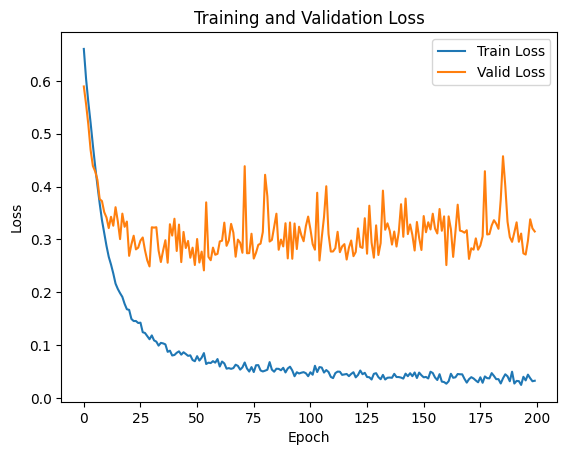

In [21]:
# 학습 결과 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [22]:
print(train_losses, valid_losses, best_accuracy)

[0.6604211523098428, 0.6033750560490413, 0.559111099375328, 0.5202595117848476, 0.47810802998841134, 0.43868570253825473, 0.4023237635517487, 0.3680027576917874, 0.3365968081417251, 0.31194357739191025, 0.28786060166607574, 0.2670319399640013, 0.2524690912253378, 0.23561846094387948, 0.21635364398409324, 0.20626432280967055, 0.19827733591247992, 0.19124837362838237, 0.17811821282531506, 0.167855821754354, 0.1666807798887516, 0.14952118107159626, 0.14555049941565282, 0.14560952442406822, 0.1418484118240594, 0.14248603848591201, 0.1244184175581885, 0.12292240420203046, 0.11705422284476188, 0.11111954784861118, 0.11836758003448485, 0.10891167051133288, 0.1065663352085259, 0.09905780386281916, 0.10422941800677162, 0.10325124071201496, 0.10137430654938867, 0.08723856670460965, 0.08951796834182268, 0.08039084845861476, 0.0813400635841322, 0.08552181305063215, 0.08821073391103686, 0.0819151144521771, 0.08648341185997038, 0.08326155794876434, 0.07969664576801785, 0.08065247494711016, 0.0718253

In [23]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs1, inputs2, labels in tqdm.tqdm(test_loader, total=len(test_loader)):
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
            outputs = model(inputs1, inputs2)
            outputs = outputs.squeeze()
            # 이진 분류 문제이므로 0.5를 기준으로 양성(1) 또는 음성(0)으로 분류합니다.
            predicted = (outputs > 0.5).long()
            predictions.extend(predicted.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())

    return predictions, true_labels

# 모델 평가
predictions, true_labels = evaluate_model(model, test_loader)

# 오차 행렬 계산
conf_matrix = confusion_matrix(true_labels, predictions)

print("Confusion Matrix:")
print(conf_matrix)


100%|██████████| 261/261 [00:02<00:00, 91.77it/s]

Confusion Matrix:
[[ 889  153]
 [  30 1012]]


In [24]:
def calculate_precision_recall(conf_matrix):
    true_positives = conf_matrix[1, 1]
    false_positives = conf_matrix[0, 1]
    false_negatives = conf_matrix[1, 0]
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return precision, recall

# 오차 행렬로부터 재현율과 정밀도 계산
precision, recall = calculate_precision_recall(conf_matrix)

print("Precision:", precision)
print("Recall:", recall)


Precision: 0.8686695278969957
Recall: 0.9712092130518234


In [25]:
def calculate_f1_score(precision, recall):
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score

# 정밀도, 재현율로부터 F1-score 계산
f1_score = calculate_f1_score(precision, recall)

print("F1-score:", f1_score)


F1-score: 0.9170820117806977
